# Wrocław, Chapter Library, MS 148

In [6]:
rebuild = False

## Data Preparation

### Modules, metadata, language models

In [1]:
import csv
import spacy
from spacy.language import Language
import re
import os
from modules.process import Text
import pandas as pd
import json
import textacy
from modules.stats import CorpusStats
import collections

In [2]:
# read in metadata
texts_metadata = pd.read_csv("metadata.csv", sep=";")

In [3]:
# load language model; install if not installed
lang_model = 'la_core_web_lg'
try:
    la = spacy.load(lang_model)
except:
    !pip install https://huggingface.co/latincy/la_core_web_lg/resolve/main/la_core_web_lg-any-py3-none-any.whl
    la = spacy.load(lang_model)
la.add_pipe('sentencizer', config={"punct_chars": [":", "."]})

# alternative model
# la = spacy.load('la_vectors_floret_lg')
# lat = textacy.load_spacy_lang('la_vectors_floret_lg') #vectors for Latin
# lat.add_pipe('sentencizer', config={"punct_chars": [":", "."]})

### Text processing

In [4]:
# initialize textacy objects
docs_clean = textacy.Corpus(lang=la)
docs_normalized = textacy.Corpus(lang=la)

In [7]:
# read texts from metadata table
if rebuild == True:
    for index, row in texts_metadata.iterrows():
        txt = Text(row["path"], name=row["id"])
        headers=row["headers"].split(",")
        txt.readFromCsv(headers = headers)
        txt.cleanText()
        txt.normalizeText() # convert j -> i etc.
        txt.saveText()
    with open(txt.clean_text_path, "r") as f:
        docs_clean.add_doc(textacy.make_spacy_doc((f.read(), {"title":name}), lang=la))
    #    docs_clean.[name]["doc"] = textacy.make_spacy_doc(f.read(), lang=la)
    with open(txt.normalized_text_path, "r") as f:
        docs_normalized.add_doc(textacy.make_spacy_doc((f.read(), {"title":name}), lang=la))
    #    docs_normalized[name]["doc"] = textacy.make_spacy_doc(f.read(), lang=la)   
    docs_clean.save("./data/docs_clean.bin.gz")
    docs_normalized.save("./data/docs_normalized.bin.gz")
else:
    docs_clean = textacy.Corpus.load(lang_model, "./data/docs_clean.bin.gz")
    docs_normalized = textacy.Corpus.load(lang_model, "./data/docs_normalized.bin.gz")
#docs_clean = textacy.Corpus.load("la_vectors_floret_lg", "./data/docs_clean.bin.gz")
#docs_normalized = textacy.Corpus.load("la_vectors_floret_lg", "./data/docs_normalized.bin.gz")

### Basic stats

In [8]:
# count and display corpus stats
corpus_stats = pd.DataFrame.from_records(
    [("clean", docs_clean.n_docs, docs_clean.n_sents, docs_clean.n_tokens),
    ("normalized", docs_normalized.n_docs, docs_normalized.n_sents, docs_normalized.n_tokens)],
    columns = ["corpus", "docs", "sents", "tokens"]
)
corpus_stats.style.hide()

corpus,docs,sents,tokens
clean,2,2368,35622
normalized,2,2373,35614


In [9]:
# count stats for corpus texts
corpora = [("docs_clean", docs_clean), ("docs_normalized",docs_normalized)]
stats_corpora = {}
for corpus in corpora:
    stats_corpora[corpus[0]] =  CorpusStats(corpus[0])
    stats_corpora[corpus[0]].getStats(corpus[1])
# unpacking the object: stats_corpora["docs_clean"].docs[0].stats

In [10]:
ngrams_df = []
for doc in stats_corpora["docs_clean"].docs:
    ngrams_df.append(pd.DataFrame(
        doc.topNgrams(nn=doc.ngrams.keys()))
                     .sort_values(["n","freq"],ascending=[True,False])
                     .groupby("n")
                     .head(5)
                    ) # get list of top n-grams for all n-grams
for df in ngrams_df:
    print(df)

     n                                              ngram  freq
0    2                                       famulum tuum    13
1    2                              Omnipotens sempiterne     8
2    2                                    sempiterne deus     8
3    2                                    spiritus sancti     6
4    2                                       hunc famulum     6
..  ..                                                ...   ...
60  14  abbatis episcopus debet missa celebrare et eum...     1
61  14  debet missa celebrare et eum benedicere inclin...     1
62  14  missa celebrare et eum benedicere inclinato ca...     1
63  14  eum benedicere inclinato capite cum duobus uel...     1
64  14  benedicere inclinato capite cum duobus uel tri...     1

[65 rows x 3 columns]
     n                                              ngram  freq
0    2                                      domini nostri    38
1    2                                    Spiritus sancti    34
2    2           

In [11]:
# top ngrams
ngrams_df = []
for doc in stats_corpora["docs_clean"].docs:
    ngrams_df.append(pd.DataFrame(
        doc.topNgrams(nn=doc.ngrams.keys()))
                     .sort_values(["n","freq"],ascending=[True,False])
                     .groupby("n")
                     .head(5)
                    ) # get list of top n-grams for all n-grams
for df in ngrams_df:
    print(df)

     n                                              ngram  freq
0    2                                       famulum tuum    13
1    2                              Omnipotens sempiterne     8
2    2                                    sempiterne deus     8
3    2                                    spiritus sancti     6
4    2                                       hunc famulum     6
..  ..                                                ...   ...
60  14  abbatis episcopus debet missa celebrare et eum...     1
61  14  debet missa celebrare et eum benedicere inclin...     1
62  14  missa celebrare et eum benedicere inclinato ca...     1
63  14  eum benedicere inclinato capite cum duobus uel...     1
64  14  benedicere inclinato capite cum duobus uel tri...     1

[65 rows x 3 columns]
     n                                              ngram  freq
0    2                                      domini nostri    38
1    2                                    Spiritus sancti    34
2    2           

In [13]:
# ngram intersection
for n in range(2,15):
    print("common " + str(n) + "-grams")
    print(set.intersection(set([span.text for span in stats_corpora["docs_normalized"]["WR148"]["ngrams"][n]]),
                     set([span.text for span in stats_corpora["docs_normalized"]["EpCrac"]["ngrams"][n]])))

common 2-grams


TypeError: 'CorpusStats' object is not subscriptable

In [14]:
# doc stats
lemma_count_docs = pd.DataFrame.from_dict(docs_normalized.word_doc_counts(by="lemma_"), orient="index", columns=["count"]).reset_index()
lemma_count_docs.rename(columns={"index" : "lemma"})
word_count_docs = pd.DataFrame.from_dict(docs_normalized.word_doc_counts(by="lemma_"), orient="index", columns=["count"]).reset_index()
word_count_docs = word_count_docs.rename(columns={"index" : "word"})

In [15]:
word_count_per_doc = {}
for doc in docs_normalized:
    name = doc._.meta["title"]
    word_count_per_doc.setdefault(name,())
    counter = collections.Counter( [ (token.orth_, token.lemma_) for token in doc if token.orth_ not in ["(", ")", "\n", "):", ":", ",", "."] ])
    word_count_per_doc[name] = counter.items()

In [16]:
word_count_per_doc_df = pd.DataFrame(word_count_per_doc["WR148"], columns=["word","count"]).sort_values("count")
word_count_per_doc_df[["word", "lemma"]] = [ (w,l) for w,l in word_count_per_doc_df["word"] ]

In [17]:
#hapax lemmas
lemma_count_per_doc_df = word_count_per_doc_df.groupby(["lemma"]).size().reset_index()
lemma_count_per_doc_df = lemma_count_per_doc_df.rename(columns={0:"count"})
#lemma_count_per_doc_df = word_count_per_doc_df.groupby("lemma").count().sort_values("count").reset_index()
lemma_count_per_doc_df[lemma_count_per_doc_df["count"] == 1]

,lemma,count
0,,1
1,\n,1
2,\n,1
3,\ns,1
4,(h)elya,1
...,...,...
4168,zona,1
4169,«,1
4170,»,1
4171,„,1


In [18]:
#hapax words
list(word_count_per_doc_df[word_count_per_doc_df["count"] == 1]["word"].sort_values())[0:10]

['..',
 '....',
 '/eo/',
 '1uditium',
 '348',
 '483',
 '491ad',
 'a.',
 'abbatissam',
 'abdenago']

In [19]:
import difflib
matcher = difflib.SequenceMatcher(lambda x: x in "\t\.\,\;\[\]" ,docs_normalized[0].text,docs_normalized[1].text)
#difflib.get_close_matches()
matcher.find_longest_match()
matches = matcher.get_matching_blocks()
matches_txt = [ docs_normalized[0].text[match.a:match.a+match.size-1] for match in matches ]
#[m for m in matches_txt if len(m) > 3]

In [20]:
# token similarity
print(textacy.similarity.tokens.jaccard([tok.norm_ for tok in docs_normalized[0] ], [ tok.norm_ for tok in docs_normalized[1] ] ))
print(textacy.similarity.tokens.cosine([tok.norm_ for tok in docs_normalized[0] ], [ tok.norm_ for tok in docs_normalized[1] ] ))
print(textacy.similarity.tokens.sorensen_dice([tok.norm_ for tok in docs_normalized[0] ], [ tok.norm_ for tok in docs_normalized[1] ] ))
print(textacy.similarity.tokens.tversky([tok.norm_ for tok in docs_normalized[0] ], [ tok.norm_ for tok in docs_normalized[1] ] ))
print(textacy.similarity.sequences.matching_subsequences_ratio([tok.norm_ for tok in docs_normalized[0] ], [ tok.norm_ for tok in docs_normalized[1] ] ))

0.13191489361702127
0.3203813507492958
0.23308270676691728
0.7425149700598802
0.03756949514235974


In [21]:
#hybrid similarity
print(textacy.similarity.hybrid.token_sort_ratio([tok.norm_ for tok in docs_normalized[0] ], [ tok.norm_ for tok in docs_normalized[1] ] )) #long
print(textacy.similarity.hybrid.monge_elkan([tok.norm_ for tok in docs_normalized[0] ], [ tok.norm_ for tok in docs_normalized[1] ] )) #looong

0.10821117986883488
0.924624856958628


In [ ]:
#docs_normalized[0]

In [22]:
# doc and sentence vectors
sims = []
for i, sent1 in enumerate(docs_normalized[0].sents):
    print("doc1: ", i)
    for j, sent2 in enumerate(docs_normalized[1].sents):
        #print("==>doc2: ", j)
        sims.append((i,j,sent1.similarity(sent2)))

doc1:  0
doc1:  1
doc1:  2
doc1:  3
doc1:  4
doc1:  5
doc1:  6
doc1:  7
doc1:  8
doc1:  9
doc1:  10
doc1:  11
doc1:  12
doc1:  13
doc1:  14
doc1:  15
doc1:  16
doc1:  17
doc1:  18
doc1:  19
doc1:  20
doc1:  21
doc1:  22
doc1:  23
doc1:  24
doc1:  25
doc1:  26
doc1:  27
doc1:  28
doc1:  29
doc1:  30
doc1:  31
doc1:  32
doc1:  33
doc1:  34
doc1:  35
doc1:  36
doc1:  37
doc1:  38
doc1:  39
doc1:  40
doc1:  41
doc1:  42
doc1:  43
doc1:  44
doc1:  45
doc1:  46
doc1:  47
doc1:  48
doc1:  49
doc1:  50
doc1:  51
doc1:  52
doc1:  53
doc1:  54
doc1:  55
doc1:  56
doc1:  57
doc1:  58
doc1:  59
doc1:  60
doc1:  61
doc1:  62
doc1:  63
doc1:  64
doc1:  65
doc1:  66
doc1:  67
doc1:  68
doc1:  69
doc1:  70
doc1:  71
doc1:  72
doc1:  73
doc1:  74
doc1:  75
doc1:  76
doc1:  77
doc1:  78
doc1:  79
doc1:  80
doc1:  81
doc1:  82
doc1:  83
doc1:  84
doc1:  85
doc1:  86
doc1:  87
doc1:  88
doc1:  89
doc1:  90
doc1:  91
doc1:  92
doc1:  93
doc1:  94
doc1:  95
doc1:  96
doc1:  97
doc1:  98
doc1:  99
doc1:  100

In [23]:
# sentence lengths
lens = []
for i, sent1 in enumerate(docs_normalized[0].sents):
    for j, sent2 in enumerate(docs_normalized[1].sents):
        lens.append((len(sent1), len(sent2)))

In [24]:
import pandas as pd
sents_sims = pd.DataFrame(sims,columns=["doc1", "doc2", "sim"])
# add sentence lengths
sents_sims[["doc1_len","doc2_len"]] = lens

sents = []
for docc in docs_normalized:
    docc_sents = []
    for sent in docc.sents:
        docc_sents.append(sent)
    sents.append(docc_sents)
sents_sims["doc1_txt"] = [ str(sents[0][d]) for d in sents_sims["doc1"] ]
sents_sims["doc2_txt"] = [ str(sents[1][d]) for d in sents_sims["doc2"] ]
sents_sims.to_csv("sents_sims.csv")

In [25]:
#most similar sentences longer than N words
sents_sims_100 = sents_sims[ (sents_sims["doc1_len"] > 5) & (sents_sims["doc2_len"] > 5) ].nlargest(100, "sim")
sents_sims_100.to_csv("sents_sims_100.csv")

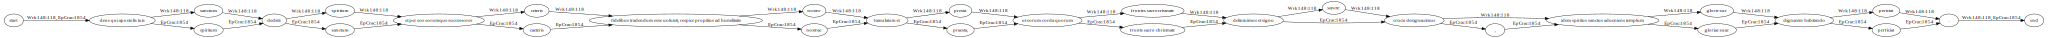

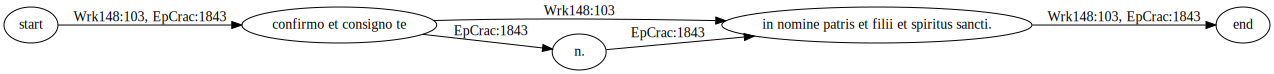

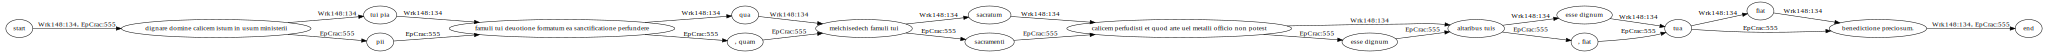

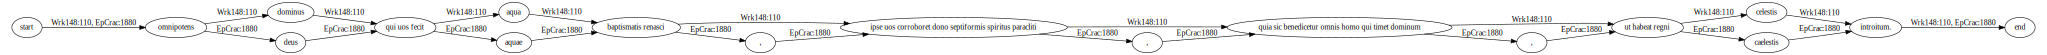

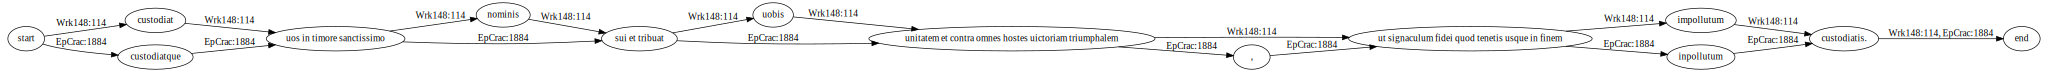

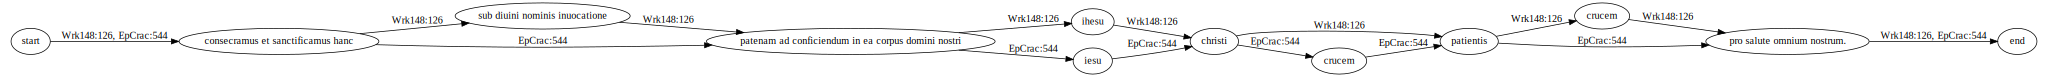

In [26]:
!pip install graphviz collatex levenshtein
import pandas as pd
sents_sims_100 = pd.read_csv("sents_sims_100.csv")
import graphviz as graphviz
import collatex
collations = []
for sent in sents_sims_100.itertuples():
    collation = collatex.Collation()
    collation.add_plain_witness("Wrk148:" + str(sent.doc1), sent.doc1_txt.lower())
    collation.add_plain_witness("EpCrac:" + str(sent.doc2), sent.doc2_txt.lower())
    collations.append(collation)
for i, coll in enumerate(collations[0:10]):
    img = collatex.collate(coll,"svg_simple")

In [27]:
sents_sims_100

,Unnamed: 0,doc1,doc2,sim,doc1_len,doc2_len,doc1_txt,doc2_txt
0,317248,145,568,0.988147,129,144,\ndomine deus pater omnipotens rex et magnific...,"\ndomine deus pater omnipotens, rex ac magnifi..."
1,259566,118,1854,0.985023,51,53,\ndeus qui apostolis tuis sanctum dedisti spir...,\ndeus qui apostolis tuis spiritum dedisti san...
2,130175,59,1319,0.984831,67,72,\nbenedic domine ihesu christe hanc creaturam ...,\nbenedic domine iesu christe hanc creaturam c...
3,226795,103,1843,0.984071,14,15,\nconfirmo et consigno te in nomine patris et ...,\nconfirmo et consigno te n. in nomine patris ...
4,151990,69,1294,0.983940,66,75,\nomnipotens sempiterne deus qui hodierna die ...,"\nomnipotens sempiterne deus, qui hodierna die..."
...,...,...,...,...,...,...,...,...
95,325037,148,1805,0.938432,102,133,\nomnipotens sempiterne deus qui per moisen fa...,"impetum uero daemonum, uel incursionem spiritu..."
96,323854,148,622,0.938260,102,112,\nomnipotens sempiterne deus qui per moisen fa...,"\ndomine deus omnipotens, qui moysi famulo tuo..."
97,269194,123,562,0.938052,56,87,\ndeus qui digne tibi seruientium nos imitari ...,"\n domine deus omnipotens, qui ab initio homin..."
98,130997,59,2141,0.937939,67,49,\nbenedic domine ihesu christe hanc creaturam ...,\ndeus et pater domini nostri iesu christi qui...


In [28]:
# most common in normalized dif
import difflib
matcher = difflib.SequenceMatcher(lambda x: x in "\t\.\,\;\[\]" ,docs_normalized[0].text,docs_normalized[1].text)
#difflib.get_close_matches()
matcher.find_longest_match()
matches = matcher.get_matching_blocks()
matches_txt = [ docs_normalized[0].text[match.a:match.a+match.size-1] for match in matches ]
[m for m in matches_txt if len(m) > 3]

['ique', ' qui', 'ific', ' dig', ' in ']

In [ ]:
import collatex
import pickle
collation = collatex.Collation()
collation.add_plain_witness("WRk_148", docs_normalized[0].text)
collation.add_plain_witness("EpCrac", docs_normalized[1].text)
import time
print(time.time())
collation_table = collatex.collate(collation,
                                   output="json")
with open("materialy/collation.json") as f:
    pick.dump(collation_table, f)
print(time.time())

1719770473.060681


In [ ]:
print(f'{doc[1].text} {doc[1].norm_}, {doc[1].lemma_}, {doc[1].pos_}')

In [ ]:
from spacy.attrs import ORTH, LOWER, POS, LEMMA, NORM
import pandas as pd
#f_lemma = pd.DataFrame.from_dict(doc.count_by(LEMMA), orient="index")

In [ ]:
doc_array = doc.to_array([ORTH, LOWER, POS, LEMMA])
doc_pd = pd.DataFrame(doc_array, columns=["orth_id", "lower_id", "pos_id", "lemma_id"])
doc_str_array = [[doc.vocab.strings[doc_array[i][0]] , 
                  doc.vocab.strings[doc_array[i][1]] ,
                  doc.vocab.strings[doc_array[i][2]] ,
                  doc.vocab.strings[doc_array[i][3]].lower()
                 ] for i in range(0, len(doc_array))]

In [ ]:
doc_pd = pd.concat([doc_pd, 
                   pd.DataFrame.from_records(doc_str_array, columns=["orth", "lower", "pos", "lemma"])], axis=1
                  ).reindex()
drop = doc_pd[doc_pd["orth"].str.contains('[\n\.,]', regex=True) ].index
doc_pd = doc_pd.drop(drop).reset_index()
doc_pd.head()

In [ ]:
import plotly.express as px

In [ ]:
px.bar(doc_pd["pos"].value_counts())

In [ ]:
# most frequent terms
doc_pd["lemma"].value_counts().sort_values(ascending=False).head(20)

In [ ]:
# hapax legomena - lemmas
doc_pd_counts = pd.DataFrame(doc_pd.groupby(["lemma"]).size()).reset_index()
doc_pd_counts = doc_pd_counts.rename(columns={0:'count'}).sort_values("count",ascending=False)
doc_pd_counts[doc_pd_counts["count"] == 1]

In [43]:
px.scatter(x=doc_pd_counts["lemma"],y=doc_pd_counts["count"])

In [44]:
px.histogram(doc_pd_counts["count"])

In [45]:
# hapax legomena - words
doc_pd_counts_orth = pd.DataFrame(doc_pd.groupby(["orth"]).size()).reset_index()
doc_pd_counts_orth = doc_pd_counts_orth.rename(columns={0:'count'}).sort_values("count",ascending=False)
doc_pd_counts_orth[doc_pd_counts_orth["count"] == 1]

,orth,count
4781,persecutor,1
4793,persuasionibus,1
4794,pertinax,1
4954,possessione,1
6683,triumphatorem,1
...,...,...
2903,humiliamur,1
2902,humili,1
2901,humerum,1
2898,humanitate,1


In [46]:
px.scatter(x=doc_pd_counts_orth["orth"],y=doc_pd_counts_orth["count"])

In [47]:
px.histogram(doc_pd_counts["count"])

In [48]:
#word length
doc_pd_counts_orth["length"] = doc_pd_counts_orth["orth"].apply(len)
doc_pd_counts_orth

,orth,count,length
2189,et,1403,2
3075,in,683,2
9,:,433,1
7122,ut,413,2
4701,per,393,3
...,...,...,...
2903,humiliamur,1,10
2902,humili,1,6
2901,humerum,1,7
2898,humanitate,1,10


In [49]:
px.histogram(doc_pd_counts_orth["length"])

In [50]:
#simple stats
from textacy.text_stats import basics, counts, diversity, readability
for m in [text_stats.basics.n_sents, 
          text_stats.basics.n_words,
          text_stats.basics.n_unique_words, 
          #text_stats.basics.n_chars_per_word,
          text_stats.basics.n_long_words,
          basics.entropy
          #text_stats.basics.n_syllables_per_word
         ]:
    print(str(m), ":", m(doc))

NameError: name 'text_stats' is not defined

In [51]:
for m in [diversity.ttr, diversity.log_ttr, diversity.segmented_ttr, diversity.mtld, diversity.hdd]:
    print(str(m), ":", m(doc))

<function ttr at 0x73f535a3a9e0> : 0.2689577464788732
<function log_ttr at 0x73f535a3aa70> : 0.8711234761673515
<function segmented_ttr at 0x73f535a3ab00> : 0.8695488721804511
<function mtld at 0x73f535a3ab90> : 168.59752319191125
<function hdd at 0x73f535a3acb0> : 0.9279344361515276


In [52]:
for m in [readability.automated_readability_index, readability.automatic_arabic_readability_index, readability.coleman_liau_index,
          readability.flesch_kincaid_grade_level, readability.flesch_reading_ease, readability.gulpease_index]:
    print(str(m), ":", m(doc))

<function automated_readability_index at 0x73f535a3b2e0> : 12.526200554093798
<function automatic_arabic_readability_index at 0x73f535a3b370> : 516600.6155372089
<function coleman_liau_index at 0x73f535a3b400> : 16.552876902272303


KeyError: None

In [53]:
#ngrams
from textacy import extract
list(extract.ngrams(doc, 3, filter_punct=True))

[ordo ad benedicendam,
 primum ueniat episcopus,
 ueniat episcopus indutus,
 episcopus indutus uestimentibus,
 indutus uestimentibus similiter,
 similiter et clerus,
 clerus ad eum,
 reliquiae preterita nocte,
 nocte cum uigiliis,
 uigiliis fuerunt fiant,
 fuerunt fiantque,
 fiantque ibi,
 que ibi laetaniae,
 dicit episcopus hanc,
 episcopus hanc orationem,
 aufer a nobis,
 a nobis iniquitates,
 nobis iniquitates nostras,
 iniquitates nostras quesumus,
 nostras quesumus domine,
 quesumus domine deus,
 domine deus noster,
 ut ad sancta,
 sancta sanctorum puris,
 sanctorum puris mereamur,
 puris mereamur mentibus,
 mereamur mentibus introire,
 alia post ingressum,
 fac nos domine,
 domine sanctorum tuorum,
 sanctorum tuorum tibi,
 tuorum tibi specialiter,
 tibi specialiter dicata,
 specialiter dicata membra,
 dicata membra contingere,
 quorum cupimus patrocinia,
 cupimus patrocinia incessanter,
 patrocinia incessanter habere,
 exorcizo te creatura,
 te creatura salis,
 salis per deum,
 d

# Sequence analysis

In [54]:
import pandas as pd
prg = pd.read_csv('materialy/PRG_new.csv',sep='\t',dtype=str)
prg = prg.melt(["id","chapter"], var_name="ms", value_name="order")
prg["order"] = prg["order"].str.split(",") #multivalue cells
prg = prg.explode("order")
prg[(prg["ms"] == "WR148") & (prg["id"] == ("40_2"))]

,id,chapter,ms,order
9261,40_2,XL. Ordo ad benedicendam ecclesiam part 2,WR148,11


In [55]:
prg = prg.astype({'order' : 'int32'},errors='ignore')
prg = prg.dropna()
prg.sort_values('order').groupby('ms', observed=False)["id"]
prg["id"] = prg["id"].astype("category")
prg["ms"] = prg["ms"].astype("category")
prg["chapter"] = prg["chapter"].astype("category")
prg["chapter_id"] = prg["id"].cat.codes
prg["ms_id"] = prg["ms"].cat.codes + 1 + prg["id"].cat.codes.max()

In [56]:
chaps = pd.DataFrame.drop_duplicates(prg[["chapter_id","id","chapter"]]).sort_values("chapter_id").apply(lambda row: ((row.iloc[0], dict(type="chapter", label=row.iloc[2])))  ,axis=1)
chaps_to_lbls = {ch[0] : ch[1]["label"] for ch in chaps}
mss = pd.DataFrame.drop_duplicates(prg[["ms_id","ms"]]).sort_values("ms_id").apply(lambda row: ((row.iloc[0], dict(type="ms", label=row.iloc[1])))  ,axis=1)
mss_to_lbls = {ms[0] : ms[1]["label"] for ms in mss }
rels = [ (i[0],i[1]) for i in zip(prg["chapter_id"],prg["ms_id"]) ]

In [57]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from(chaps)
G.add_nodes_from(mss)
G.add_edges_from(rels)

In [58]:
H = G.copy()
H = nx.relabel_nodes(H, chaps_to_lbls)
H = nx.relabel_nodes(H, mss_to_lbls)
node_colors = ["blue" if node[1]["type"] == "ms" else "gray" for node in H.nodes.items()]
highlight = [i for i,node in enumerate(H.nodes.items()) if node[1]["type"] == "ms" and node[1]["label"] == "WR148"][0]
node_colors[highlight] = "red"
font_sizes = [10 if node[1]["type"] == "ms" else 2 for node in H.nodes.items()]
node_sizes = [80 if node[1]["type"] == "ms" else 5 for node in H.nodes.items()]
node_lbls = { n[0] : n[0] if n[1]["type"] == "ms" else ""  for n in H.nodes.items() }

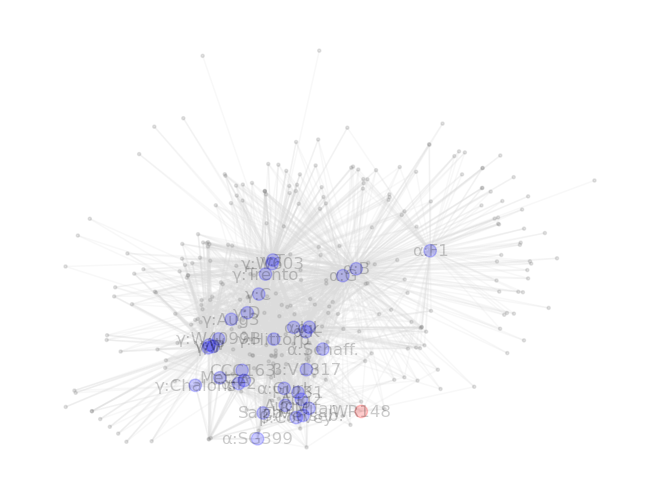

In [59]:
nx.draw(H, nx.spring_layout(H, k=0.02, seed=4572321), alpha=0.2,
        labels=node_lbls, node_color=node_colors, font_size=12, 
        node_size=node_sizes,edge_color='gainsboro', font_color='black')

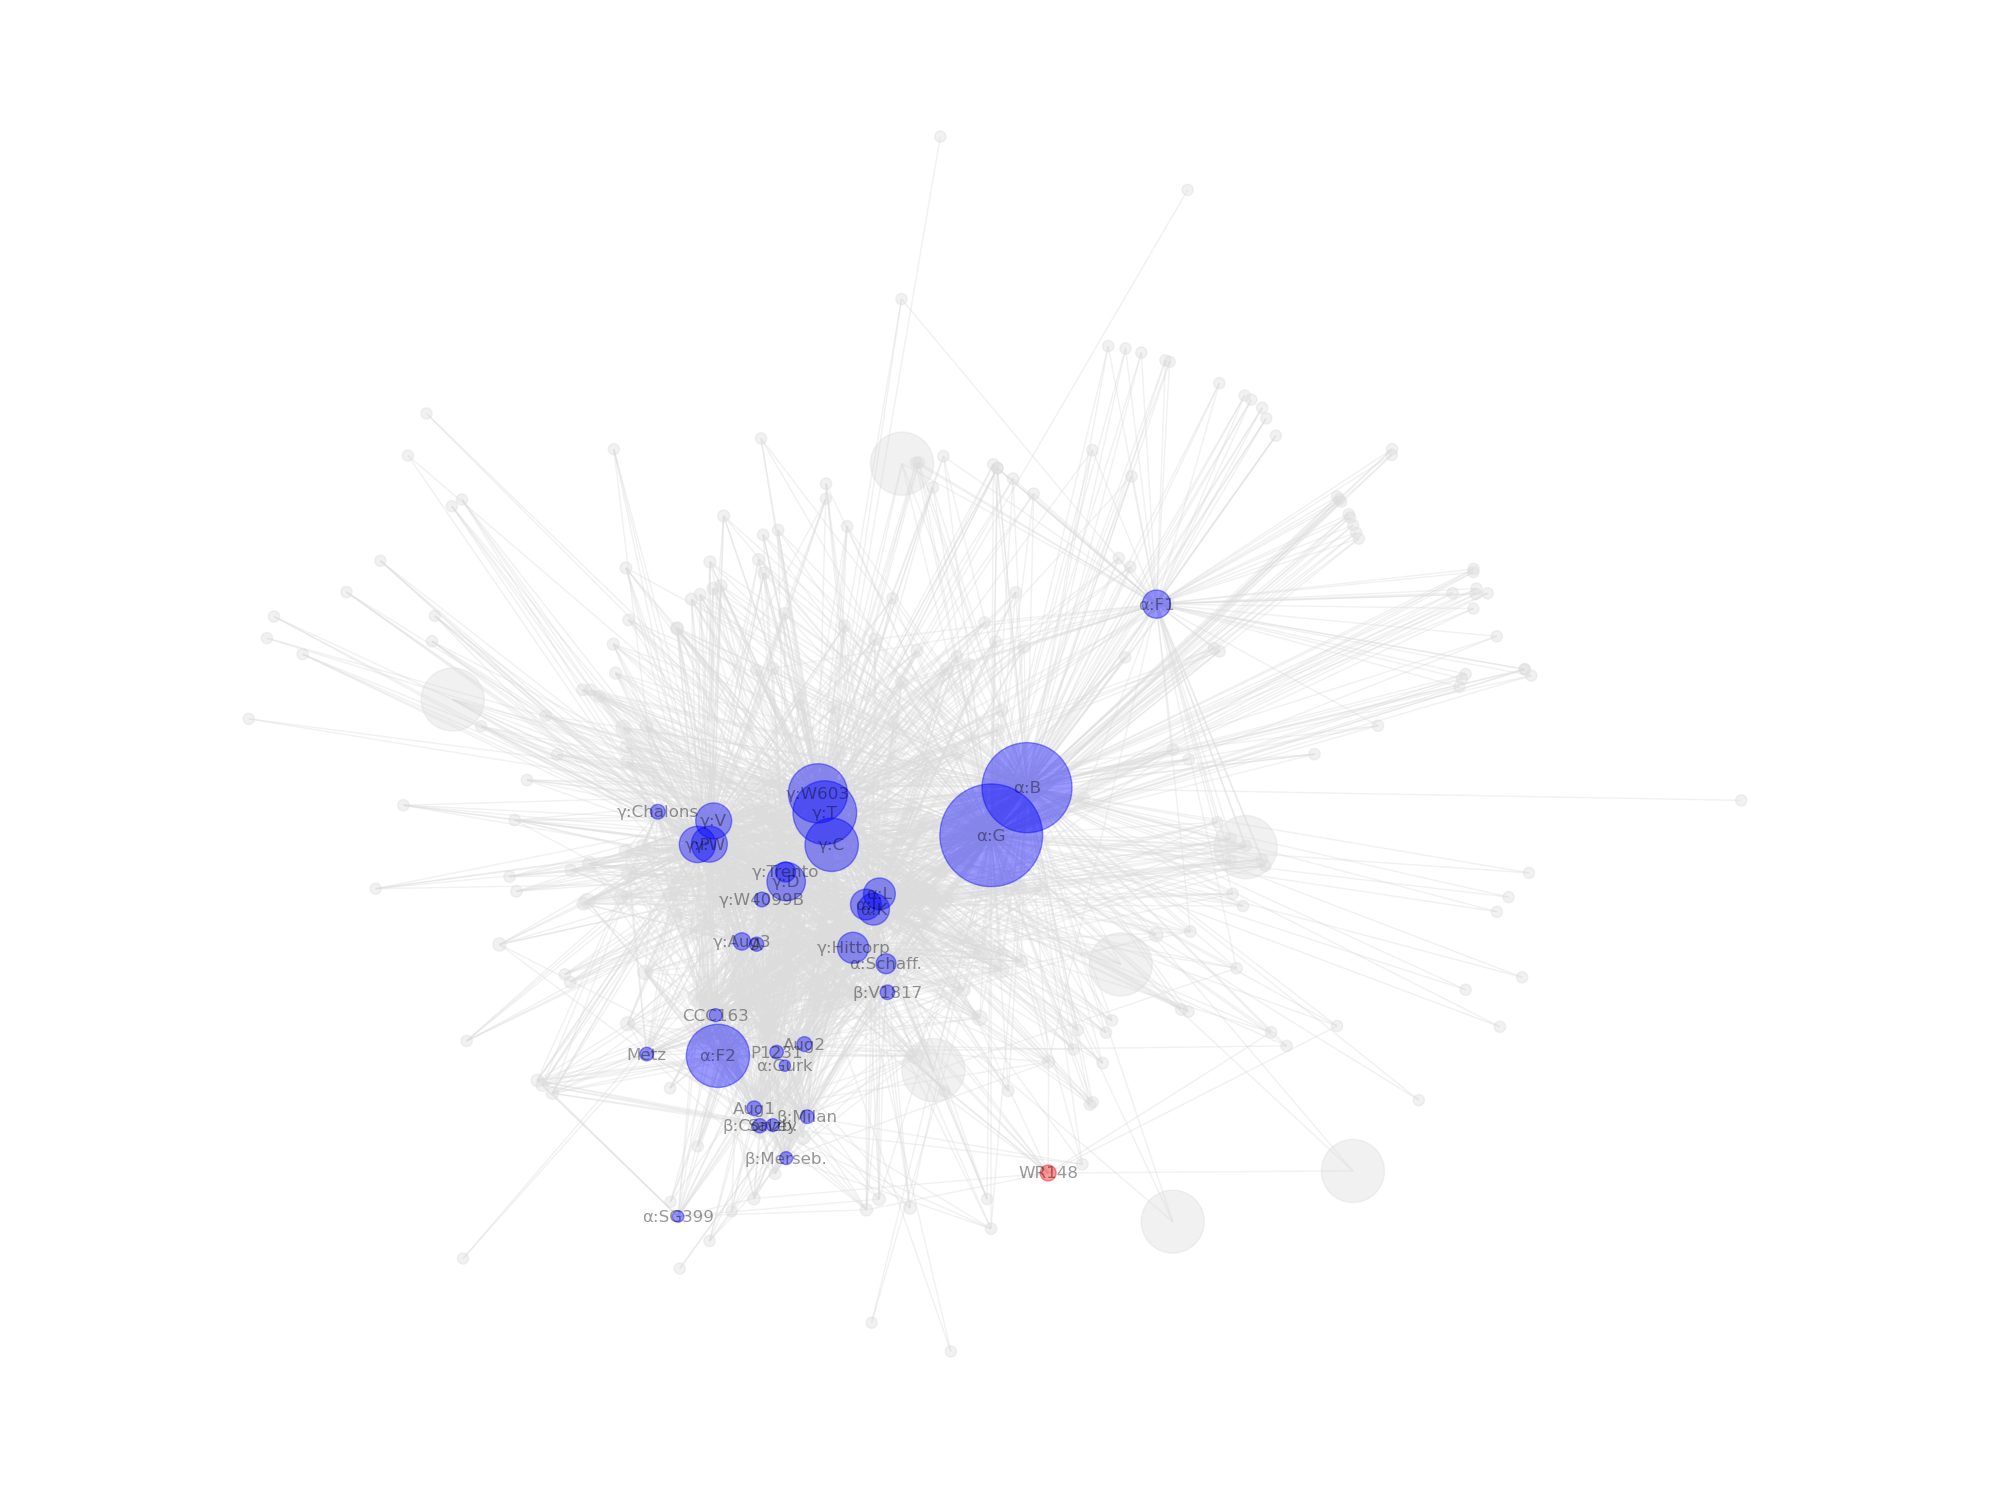

In [60]:
import matplotlib.pyplot as plt

# largest connected component
components = nx.connected_components(H)
largest_component = max(components, key=len)
I = H.subgraph(largest_component)
# compute centrality
centrality = nx.betweenness_centrality(I, k=10, endpoints=True)

# compute community structure
lpc = nx.community.label_propagation_communities(I)
community_index = {n: i for i, com in enumerate(lpc) for n in com}
I_lbls = { n[0] : n[0] if n[1]["type"] == "ms" else ""  for n in I.nodes.items() }
#### draw graph ####
fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(I, k=0.01, seed=4572321)
#node_color = [community_index[n] for n in I] #community-based
node_color = [ "blue" if n[1]["type"] == "ms" else "gainsboro"  for n in I.nodes.items() ]
highlight = [i for i,node in enumerate(I.nodes.items()) if node[1]["type"] == "ms" and node[1]["label"] == "WR148"][0]
node_color[highlight] = "red"

node_size = [v * 20000 for v in centrality.values()]
nx.draw_networkx(
    I,
    pos=pos,
    labels = I_lbls,
    #with_labels=True,
    node_color=node_color,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.4,
)
# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 20}
ax.set_title("", font)
# Change font color for legend
font["color"] = "r"

# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.savefig("closeness_presence.png",dpi=150)
plt.show()
#TODO: porównać tylko mss równowielkie
#TODO: porównywać fragmenty - wybrać empirycznie podobne

In [61]:
prg["order"] = prg["order"].astype("int")
prg = prg.sort_values(["ms","order"])
groups = prg.groupby("ms", observed=True)
seqs = { k : list(g["id"]) for k, g in groups }
seqs["WR148"]

['26',
 '99',
 '27',
 '99',
 '63',
 '244',
 '110',
 '99',
 '108',
 '40_1',
 '40_2',
 '40_3',
 '3',
 '2',
 '4',
 '246']

In [63]:
import seqsim
import textdistance
import itertools as it
# seqsim
#dists = [ ( pair[0], pair[1], seqsim.distance( [ seqs[pair[0]], seqs[pair[1]] ] ) ) for pair in it.combinations(seqs, 2) ]
import textdistance
#dists = [ ( pair[0], pair[1], 
#           textdistance.needleman_wunsch.normalized_distance( seqs[pair[0]], seqs[pair[1]] ) ) for pair in it.combinations(seqs, 2) ]
dists = [ ( pair[0], pair[1], 
           textdistance.cosine.normalized_distance( seqs[pair[0]], seqs[pair[1]] ) ) for pair in it.combinations(seqs, 2) ]
#dists

In [64]:
#seq_edges = [ (el[0], el[1], {"weight" : int(el[2])} ) for el in dists]
#seq_edges = [ (el[0], el[1], el[2] ) for el in dists]
seq_G = nx.Graph()
seq_G.add_weighted_edges_from([ ( d[0], d[1], (1-d[2])*1000 ) for d in dists])
pos = nx.spring_layout(seq_G, weight='weight', k=0.1, seed=4572321)

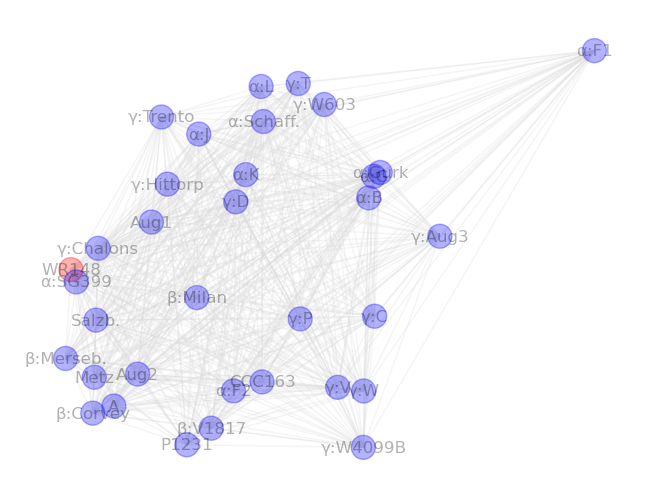

In [65]:
node_color = [ "red" if node[0] == "WR148" else "blue"  
              for node in seq_G.nodes.items() ]
#highlight = [i for i,node in enumerate(I.nodes.items()) if node[1]["type"] == "ms" and [0]
#node_color[highlight] = "red"

nx.draw(seq_G,pos = pos,with_labels=True,edge_color='gainsboro',alpha=0.3, node_color=node_color)
plt.savefig("closeness_sequence.png",dpi=150)

In [66]:
#textdistance.NeedlemanWunsch.normalized_similarity('a', 'a')
textdistance.needleman_wunsch.normalized_similarity(['test', 'text'], ['text','test'])

0.5

# Statystyki
- fundamenty statystyki leksykalnej
    - type / token ratio
    - lexical richness
    - formulaity
    - hapax legomena
- stats per textual unit
    - unit length etc.
- analiza paleograficzna per proxy
    - ilość linii, znaków
- ortografia
  - allografia: i/j, u/v, k/c/ch (nie chodzi o warianty paleograficzne)
  - warianty: sic
- sekwencja unitów (potrzeba bazy PF)
- porównanie tekstów (potrzeba korpusu: CURSUS)
    - sequence alignment
    - stylometria
